In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

import warnings
warnings.filterwarnings("ignore")
import os
import copy
import torch.nn.utils.prune as prune


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, input,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,M2=None):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    mask={}
    sk=0
    for module_name, module in M2.named_modules():
        for a,b in module.named_buffers():
          # print(sk,a,b)
          if sk == 0:
            if 'mask' in a :
              # print(a,b.shape)
              mask[a]=b
              # print(mask)

        sk+=1
        # print(sk,module_name)
        # if isinstance(module, torch.nn.Conv2d):
        #     mask.append(module)
    # print(mask)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch_number, batch in enumerate(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            # print(f"batch number{batch_number}")
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            # if batch_number ==0:
            #     for param_name,param in model.named_parameters():
            #         print(f'param_name_before \n{param}')
            #         exit()

            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                      weight_mask=f'{module_name}.weight_mask'
                      bias_mask=f'{module_name}.bias_mask'
                      module.weight.grad.mul_(mask[weight_mask])
                      module.bias.grad.mul_(mask[bias_mask])
                      # print(module_name,module.weight.grad.shape)
                      # print('crazzzzzy')
                      # print(mask[weight_mask])
            optimizer.step()
            # if batch_number ==0:
            #     for param_name,param in model.named_parameters():
            #         print(f'param_name_after\n{param}')
            #         exit()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if (epoch+1)%2==0:
            path = f'/content/drive/MyDrive/VCL/T4/M2_{(input+1)*10}%pruned_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)






def plot_accuracies(history,input):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/T4/Accuracy_vs._No. of epochs_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()


def plot_losses(history,input):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/T4/Loss_vs._No. of epochs_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()

def plot_lrs(history,input):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig(f'/content/drive/MyDrive/VCL/T4/LearningRate_vs._No. of epochs_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()

def post_finetuning_history(history,input):
    val_acc = [x.get('val_acc') for x in history]
    
    plt.plot(val_acc, '-bx')
    
    plt.xlabel('iter')
    plt.ylabel('val_acc')
    plt.legend(['Training', 'Validation'])
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T4/post_finetuning_accuracy_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()




In [3]:

import copy

def measure_sparsity(model):
  num_of_zeros,num_of_parameters=0,0
  for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            num_of_zeros+= torch.sum(module.weight == 0)
            num_of_zeros+=torch.sum(module.bias == 0)
            num_of_parameters+=module.weight.nelement()
            num_of_parameters+=module.bias.nelement()
  print(f'Global Sparsity{100*float(num_of_zeros.cpu().item())/float(num_of_parameters)}%')


def iterative_pruning_finetuning(epochs, 
                                 max_lr,
                                 model, 
                                 train_dl, valid_dl,
                                 input,
                                grad_clip=None, 
                                weight_decay=0, 
                                opt_func=torch.optim.SGD,
                                 conv2d_prune_amount=0.1,
                                 linear_prune_amount=0.2,
                                 num_iterations=1,
                                 num_epochs_per_iteration=10,
                                 grouped_pruning = True):
  
    iter_history=[]
    for i in range(num_iterations):

        
        history = [evaluate(model, valid_dl)]
        print(history)
        print("Pruning and Finetuning {}/{}".format(i + 1, num_iterations))
        M2=copy.deepcopy(model)
        # print(M2)
        # for name,param in model.named_parameters():
        #     print(name,param.shape)

        print("Pruning...")

        if grouped_pruning == True:
            # Global pruning
            # I would rather call it grouped pruning.
            parameters_to_prune = []
            for module_name, module in M2.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
                    parameters_to_prune.append((module, "bias"))
                # if isinstance(module, torch.nn.Linear):
                #     parameters_to_prune.append((module, "weight"))
                #     parameters_to_prune.append((module, "bias"))
            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=conv2d_prune_amount*(1+input),
            )
        else:
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=conv2d_prune_amount)
                elif isinstance(module, torch.nn.Linear):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=linear_prune_amount)

        
        # print(len(parameters_to_prune))
        measure_sparsity(model)
        measure_sparsity(M2)
        post_pruning_history = [evaluate(model, valid_dl)]
        print(f'post_pruning_history_{post_pruning_history}')
        # print(M2)
        # for name,param in M2.named_parameters():
        #     print(name,param.shape)
        # # print(model.conv1._forward_pre_hooks)
        # for i,j in M2.named_buffers():
        #   print(i,j.shape)
        print("Fine-tuning...")

        history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, input,
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func,M2=M2)
        plot_accuracies(history,input)
        plot_losses(history,input)
        plot_lrs(history,input)
        history = [evaluate(model, valid_dl)]
        print(history)
    return history , post_pruning_history


def remove_parameters(model):

    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
[{'val_loss': 2.3030552864074707, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity10.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2342, val_loss: 0.4382, val_acc: 0.8579
Epoch [1], train_loss: 0.4129, val_loss: 0.8484, val_acc: 0.7267
Epoch [2], train_loss: 0.5262, val_loss: 0.8026, val_acc: 0.7429
Epoch [3], train_loss: 0.5133, val_loss: 0.5654, val_acc: 0.8035
Epoch [4], train_loss: 0.4818, val_loss: 0.6428, val_acc: 0.7852
Epoch [5], train_loss: 0.4463, val_loss: 0.4865, val_acc: 0.8374
Epoch [6], train_loss: 0.3852, val_loss: 0.4289, val_acc: 0.8573
Epoch [7], train_loss: 0.3248, val_loss: 0.3427, val_acc: 0.8859
Epoch [8], train_loss: 0.2575, val_loss: 0.3004, val_acc: 0.8995
Epoch [9], train_loss: 0.1933, val_loss: 0.2618, va

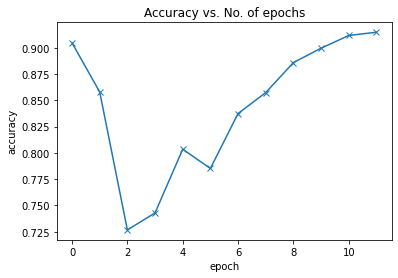

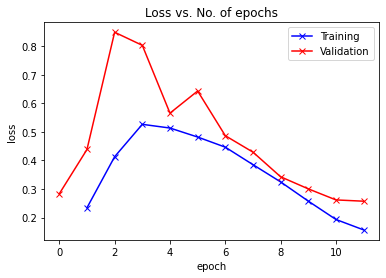

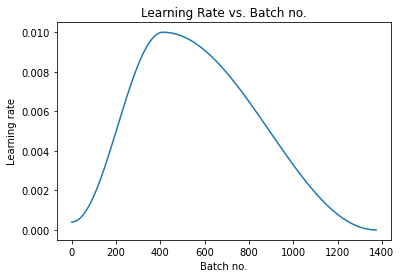

[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}]]
Files already downloaded and verified
[{'val_loss': 2.303138256072998, 'val_acc': 0.09951923787593842}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity20.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2278, val_loss: 0.6407, val_acc: 0.8133
Epoch [1], train_loss: 0.4131, val_loss: 0.8524, val_acc: 0.7247
Epoch [2], train_loss: 0.5119, val_loss: 1.2438, val_acc: 0.6411
Epoch [3], train_loss: 0.5111, val_loss: 0.5899, val_acc: 0.8006
Epoch [4], train_loss: 0.4783, val_loss: 0.6101, val_acc: 0.8001
Epoch [5], train_loss: 0.4269, val_loss: 0.5384, val_acc: 0.8239
Epoch [6], train_loss: 0.3787, val_loss: 0.4227, val_acc: 0.8568
Epoch [7], train_loss: 0.3153, val_loss: 0.4040, val_acc: 

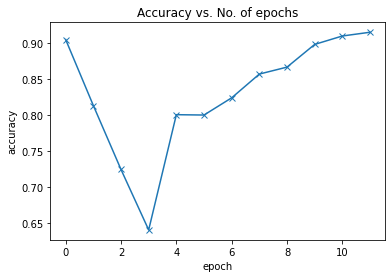

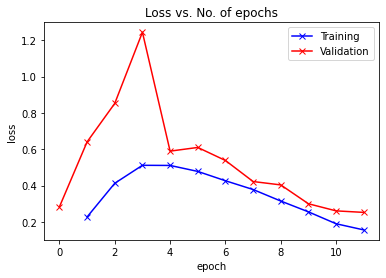

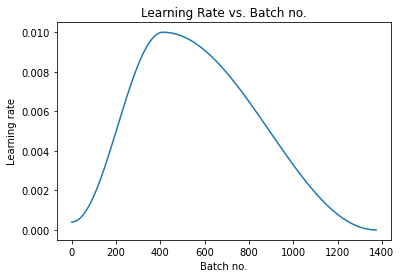

[{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}]]
Files already downloaded and verified
[{'val_loss': 2.3031163215637207, 'val_acc': 0.10019230842590332}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity30.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2315, val_loss: 0.4097, val_acc: 0.8662
Epoch [1], train_loss: 0.3974, val_loss: 0.5188, val_acc: 0.8237
Epoch [2], train_loss: 0.5053, val_loss: 0.8589, val_acc: 0.7201
Epoch [3], train_loss: 0.5009, val_loss: 0.5854, val_acc: 0.8030
Epoch [4], train_loss: 0.4680, val_loss: 0.7084, val_acc: 0.7730
Epoch [5], train_loss: 0.4250, val_loss: 0.5812, val_acc: 0.8053
Epoch [6], train_loss: 0.3745, val_loss: 0.4802, val_acc:

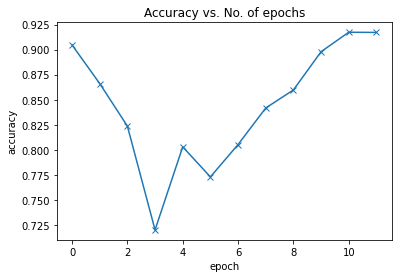

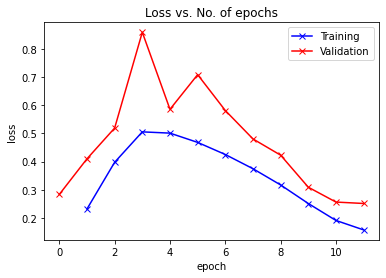

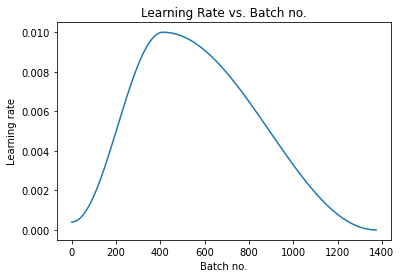

[{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}]]
Files already downloaded and verified
[{'val_loss': 2.303041458129883, 'val_acc': 0.09951923787593842}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity40.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2257, val_loss: 0.5229, val_acc: 0.8361
Epoch [1], train_loss: 0.3815, val_loss: 0.6574, val_acc: 0.7845
Epoch [2], train_loss: 0.4907, val_loss: 0.6392, val_acc: 0.7836
Epoch [3], train_loss: 0.4856, val_loss: 0.7330, val_acc: 0.7615
Epoch [4], train_loss: 0.4558, val_loss: 0.6390, val_acc: 0.7912
Epoch [5], train_loss: 0.4184, val_loss: 0.5087, val_ac

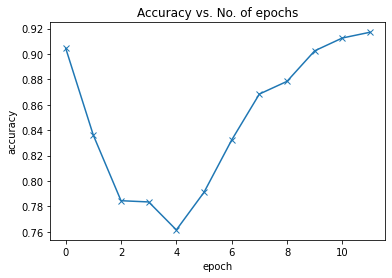

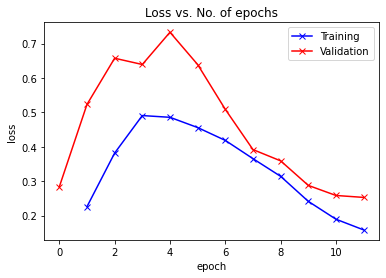

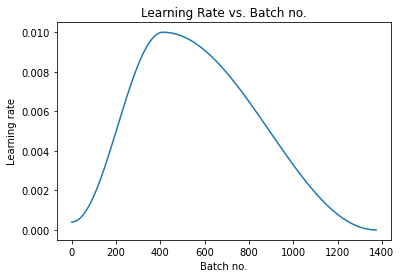

[{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}], [{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}]]
Files already downloaded and verified
[{'val_loss': 2.302978038787842, 'val_acc': 0.09990385174751282}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity50.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2232, val_loss: 0.4189, val_acc: 0.8651
Epoch [1], train_loss: 0.3686, val_loss: 0.6023, val_acc: 0.8017
Epoch [2], train_loss: 0.4804, val_loss: 0.8646, val_acc: 0.7139
Epoch [3], train_loss: 0.4808, val_loss: 0.6913, val_acc: 0.7795
Epoch [4], train_loss: 0.4424, val_loss: 0.6127, va

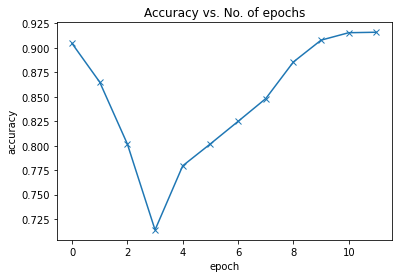

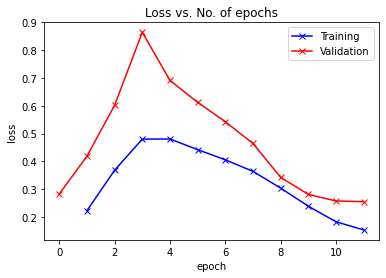

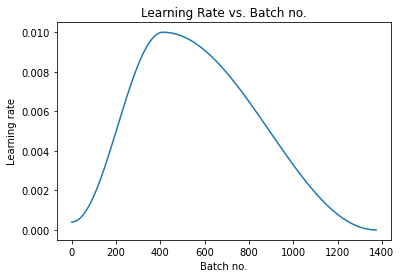

[{'val_loss': 0.25537365674972534, 'val_acc': 0.9160577058792114}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}], [{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}], [{'val_loss': 0.25537365674972534, 'val_acc': 0.9160577058792114}]]
Files already downloaded and verified
[{'val_loss': 2.302835702896118, 'val_acc': 0.10000000894069672}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity60.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2245, val_loss: 0.4161, val_acc: 0.8710
Epoch [1], train_loss: 0.3643, val_loss: 0.7104, val_acc: 0.7881
Epoch [2], train_loss: 0.4685, val_loss: 0.7865, val_acc: 0.7581
Epoch [3], train_loss: 0.4622, val_loss: 0.6659,

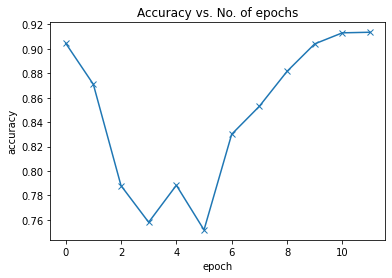

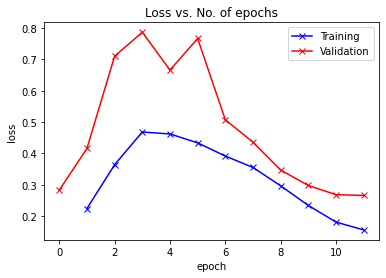

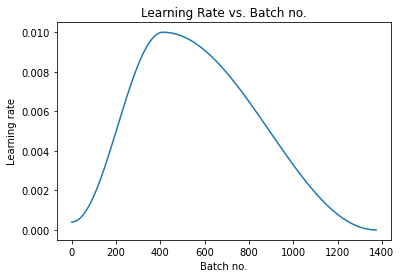

[{'val_loss': 0.266193151473999, 'val_acc': 0.9135576486587524}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}], [{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}], [{'val_loss': 0.25537365674972534, 'val_acc': 0.9160577058792114}], [{'val_loss': 0.266193151473999, 'val_acc': 0.9135576486587524}]]
Files already downloaded and verified
[{'val_loss': 2.30302357673645, 'val_acc': 0.09913460910320282}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity70.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2286, val_loss: 0.3869, val_acc: 0.8705
Epoch [1], train_loss: 0.3463, val_loss: 0.5387, val_acc: 0.8278
Epoch [2], train_loss: 0.4569, val_loss: 0.8048, v

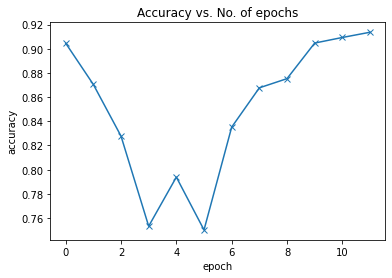

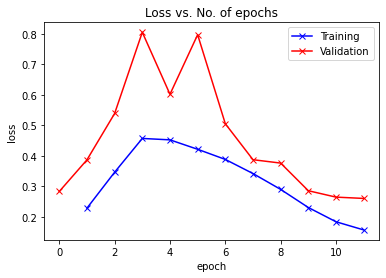

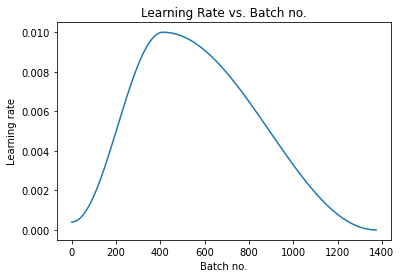

[{'val_loss': 0.2604339122772217, 'val_acc': 0.9136539101600647}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}], [{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}], [{'val_loss': 0.25537365674972534, 'val_acc': 0.9160577058792114}], [{'val_loss': 0.266193151473999, 'val_acc': 0.9135576486587524}], [{'val_loss': 0.2604339122772217, 'val_acc': 0.9136539101600647}]]
Files already downloaded and verified
[{'val_loss': 2.302985906600952, 'val_acc': 0.10028846561908722}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity80.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2389, val_loss: 0.3751, val_acc: 0.8779
Epoch [1], train_loss: 0.3504, val_loss: 0.519

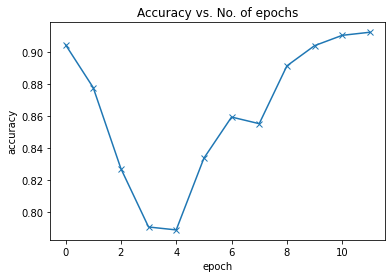

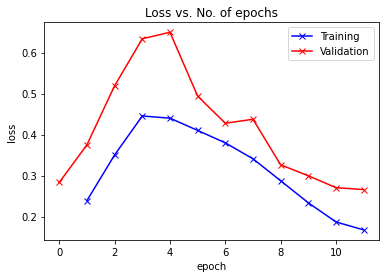

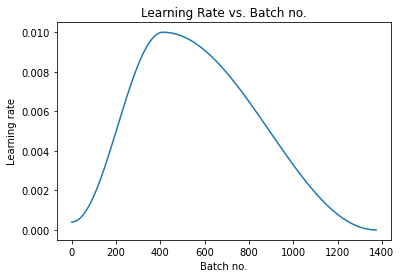

[{'val_loss': 0.2657531797885895, 'val_acc': 0.9124038219451904}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}], [{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}], [{'val_loss': 0.25537365674972534, 'val_acc': 0.9160577058792114}], [{'val_loss': 0.266193151473999, 'val_acc': 0.9135576486587524}], [{'val_loss': 0.2604339122772217, 'val_acc': 0.9136539101600647}], [{'val_loss': 0.2657531797885895, 'val_acc': 0.9124038219451904}]]
Files already downloaded and verified
[{'val_loss': 2.3027892112731934, 'val_acc': 0.10288461297750473}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity90.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2644, val_loss: 0.

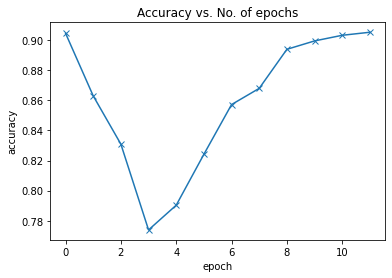

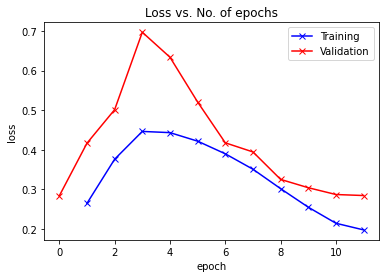

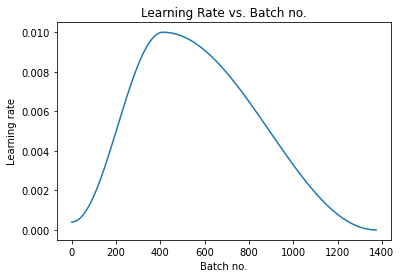

[{'val_loss': 0.2841520607471466, 'val_acc': 0.9052883982658386}]
[[{'val_loss': 0.2573049068450928, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.252887099981308, 'val_acc': 0.9147115349769592}], [{'val_loss': 0.25120019912719727, 'val_acc': 0.917115330696106}], [{'val_loss': 0.25267329812049866, 'val_acc': 0.9171154499053955}], [{'val_loss': 0.25537365674972534, 'val_acc': 0.9160577058792114}], [{'val_loss': 0.266193151473999, 'val_acc': 0.9135576486587524}], [{'val_loss': 0.2604339122772217, 'val_acc': 0.9136539101600647}], [{'val_loss': 0.2657531797885895, 'val_acc': 0.9124038219451904}], [{'val_loss': 0.2841520607471466, 'val_acc': 0.9052883982658386}]]


In [4]:
if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    percent=[]
    #iteratively pruned loaded model 
    post_finetuning_history=[]
    post_pruning_history=[]
    for i in range(9):
      stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
      train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                              tt.RandomHorizontalFlip(), 
                              # tt.RandomRotate
                              # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                              # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                              tt.ToTensor(), 
                              tt.Normalize(*stats,inplace=True)])
      valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
      # PyTorch datasets
      train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
      valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
      dataset_size = len(train_ds)
      test_dataset_size = len(valid_ds)
      # print(train_ds)
      # print(valid_ds)
      batch_size = 400

      # PyTorch data loaders
      train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
      valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
      device = get_default_device()
      # device = torch.device('cpu')
      train_dl = DeviceDataLoader(train_dl, device)
      valid_dl = DeviceDataLoader(valid_dl, device)

      model = to_device(Cifar10CnnModel(), device)
      # print(model)
      os.environ['WANDB_CONSOLE'] = 'off'
      history = [evaluate(model, valid_dl)]
      print(history)

      epochs = 11
      max_lr = 0.01
      grad_clip = 0.1
      weight_decay = 1e-4
      opt_func = torch.optim.Adam
      
      os.environ['WANDB_CONSOLE'] = 'off'
      model = to_device(Cifar10CnnModel(), device)
      percent.append((i+1)*10)
      model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt'))
      # model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt',map_location=torch.device('cpu')))
      history_final , post_pruning=iterative_pruning_finetuning(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func,input=i)
      post_finetuning_history.append(history_final)
      post_pruning_history.append(post_pruning)
      print(post_finetuning_history)
    
    

In [5]:

def post_finetuning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.plot(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T4/post_finetuning_accuracy.pdf',format='pdf')
    plt.show()
def post_pruning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.plot(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_pruning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T4/post_pruning_accuracy.pdf',format='pdf')
    plt.show()

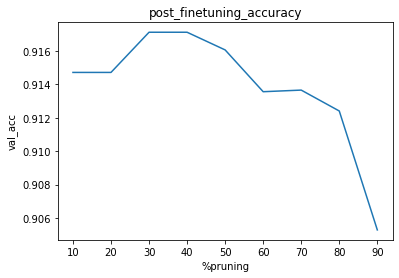

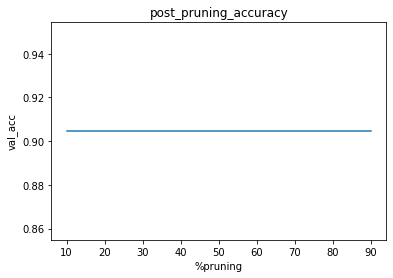

In [6]:
post_finetuning_history_plot(post_finetuning_history)
post_pruning_history_plot(post_pruning_history)

In [10]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

import warnings
warnings.filterwarnings("ignore")
import os
import copy
import torch.nn.utils.prune as prune


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, input,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,M2=None):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    mask={}
    sk=0
    for module_name, module in M2.named_modules():
        for a,b in module.named_buffers():
          # print(sk,a,b)
          if sk == 0:
            if 'mask' in a :
              # print(a,b.shape)
              mask[a]=b
              # print(mask)

        sk+=1
        # print(sk,module_name)
        # if isinstance(module, torch.nn.Conv2d):
        #     mask.append(module)
    # print(mask)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch_number, batch in enumerate(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            # print(f"batch number{batch_number}")
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            # if batch_number ==0:
            #     for param_name,param in model.named_parameters():
            #         print(f'param_name_before \n{param}')
            #         exit()

            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                      weight_mask=f'{module_name}.weight_mask'
                      bias_mask=f'{module_name}.bias_mask'
                      module.weight.grad.mul_(mask[weight_mask])
                      module.bias.grad.mul_(mask[bias_mask])
                      # print(module_name,module.weight.grad.shape)
                      # print('crazzzzzy')
                      # print(mask[weight_mask])
            optimizer.step()
            # if batch_number ==0:
            #     for param_name,param in model.named_parameters():
            #         print(f'param_name_after\n{param}')
            #         exit()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if (epoch+1)%2==0:
            path = f'/content/drive/MyDrive/VCL/T5/M2_{(float(input)/100+.9)*100}%pruned_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)






def plot_accuracies(history,input):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/T5/Accuracy_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()


def plot_losses(history,input):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/T5/Loss_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()

def plot_lrs(history,input):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig(f'/content/drive/MyDrive/VCL/T5/LearningRate_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()

def post_finetuning_history(history,input):
    val_acc = [x.get('val_acc') for x in history]
    
    plt.plot(val_acc, '-bx')
    
    plt.xlabel('iter')
    plt.ylabel('val_acc')
    plt.legend(['Training', 'Validation'])
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T5/post_finetuning_accuracy_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()




In [11]:

import copy

def measure_sparsity(model):
  num_of_zeros,num_of_parameters=0,0
  for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            num_of_zeros+= torch.sum(module.weight == 0)
            num_of_zeros+=torch.sum(module.bias == 0)
            num_of_parameters+=module.weight.nelement()
            num_of_parameters+=module.bias.nelement()
  print(f'Global Sparsity{100*float(num_of_zeros.cpu().item())/float(num_of_parameters)}%')


def iterative_pruning_finetuning(epochs, 
                                 max_lr,
                                 model, 
                                 train_dl, valid_dl,
                                 input,
                                grad_clip=None, 
                                weight_decay=0, 
                                opt_func=torch.optim.SGD,
                                 conv2d_prune_amount=0.9,
                                 linear_prune_amount=0.2,
                                 num_iterations=1,
                                 num_epochs_per_iteration=10,
                                 grouped_pruning = True):
  
    iter_history=[]
    for i in range(num_iterations):

        
        history = [evaluate(model, valid_dl)]
        print(history)
        print("Pruning and Finetuning {}/{}".format(i + 1, num_iterations))
        M2=copy.deepcopy(model)
        # print(M2)
        # for name,param in model.named_parameters():
        #     print(name,param.shape)

        print("Pruning...")

        if grouped_pruning == True:
            # Global pruning
            # I would rather call it grouped pruning.
            parameters_to_prune = []
            for module_name, module in M2.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
                    parameters_to_prune.append((module, "bias"))
                # if isinstance(module, torch.nn.Linear):
                #     parameters_to_prune.append((module, "weight"))
                #     parameters_to_prune.append((module, "bias"))
            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=conv2d_prune_amount+(float(input)/100)
            )
        else:
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=conv2d_prune_amount)
                elif isinstance(module, torch.nn.Linear):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=linear_prune_amount)

        
        # print(len(parameters_to_prune))
        measure_sparsity(model)
        measure_sparsity(M2)
        post_pruning_history = [evaluate(model, valid_dl)]
        print(f'post_pruning_history_{post_pruning_history}')
        # print(M2)
        # for name,param in M2.named_parameters():
        #     print(name,param.shape)
        # # print(model.conv1._forward_pre_hooks)
        # for i,j in M2.named_buffers():
        #   print(i,j.shape)
        print("Fine-tuning...")

        history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, input,
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func,M2=M2)
        plot_accuracies(history,input)
        plot_losses(history,input)
        plot_lrs(history,input)
        history = [evaluate(model, valid_dl)]
        print(history)
    return history , post_pruning_history


def remove_parameters(model):

    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model


Files already downloaded and verified
[{'val_loss': 2.3030357360839844, 'val_acc': 0.10019230842590332}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity90.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2613, val_loss: 0.4115, val_acc: 0.8639
Epoch [1], train_loss: 0.3744, val_loss: 0.5099, val_acc: 0.8265
Epoch [2], train_loss: 0.4506, val_loss: 0.5844, val_acc: 0.8082
Epoch [3], train_loss: 0.4441, val_loss: 0.5540, val_acc: 0.8143
Epoch [4], train_loss: 0.4195, val_loss: 0.4871, val_acc: 0.8339
Epoch [5], train_loss: 0.3838, val_loss: 0.4995, val_acc: 0.8308
Epoch [6], train_loss: 0.3421, val_loss: 0.3995, val_acc: 0.8647
Epoch [7], train_loss: 0.3044, val_loss: 0.3430, val_acc: 0.8849
Epoch [8], train_loss: 0.2560, val_loss: 0.3189, val_acc: 0.8950
Epoch [9], train_loss: 0.2147, val_loss: 0.2913, val_acc: 0.9

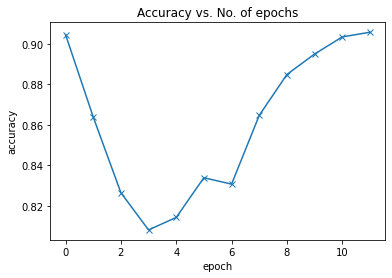

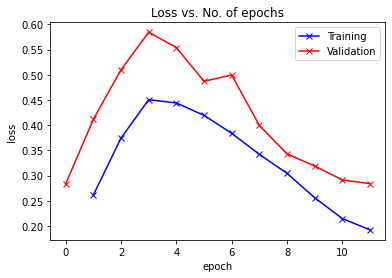

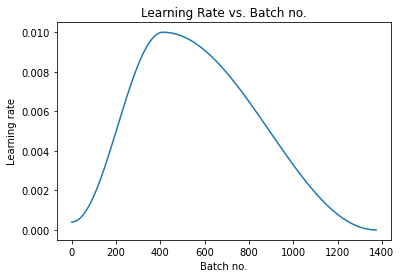

[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}]]
Files already downloaded and verified
[{'val_loss': 2.3028316497802734, 'val_acc': 0.11596153676509857}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity91.00001776072747%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2658, val_loss: 0.3946, val_acc: 0.8645
Epoch [1], train_loss: 0.3866, val_loss: 0.4863, val_acc: 0.8335
Epoch [2], train_loss: 0.4437, val_loss: 0.4984, val_acc: 0.8300
Epoch [3], train_loss: 0.4456, val_loss: 0.7104, val_acc: 0.7795
Epoch [4], train_loss: 0.4189, val_loss: 0.4990, val_acc: 0.8342
Epoch [5], train_loss: 0.3882, val_loss: 0.4803, val_acc: 0.8401
Epoch [6], train_loss: 0.3505, val_loss: 0.3761, val_acc: 0.8750
Epoch [7], train_loss: 0.3039, val_loss: 0

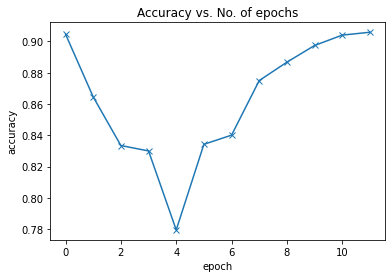

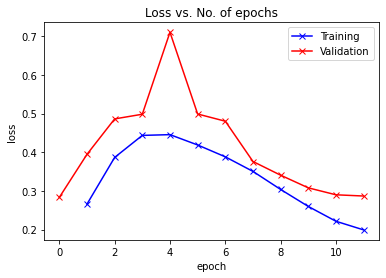

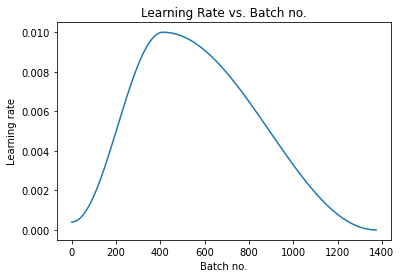

[{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}]]
Files already downloaded and verified
[{'val_loss': 2.3027634620666504, 'val_acc': 0.10028846561908722}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity92.00003552145496%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2734, val_loss: 0.4611, val_acc: 0.8455
Epoch [1], train_loss: 0.3959, val_loss: 0.5118, val_acc: 0.8276
Epoch [2], train_loss: 0.4562, val_loss: 0.5267, val_acc: 0.8237
Epoch [3], train_loss: 0.4565, val_loss: 0.5545, val_acc: 0.8223
Epoch [4], train_loss: 0.4221, val_loss: 0.4801, val_acc: 0.8423
Epoch [5], train_loss: 0.3974, val_loss: 0.4506, val_acc: 0.8446
Epoch [6], train_loss: 0.3467, val_loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [7], train_loss: 0.3116, val_loss: 0.3561, val_acc: 0.8765


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorif w.is_alive():: 
can only test a child process  File "/usr/lib/python

Epoch [8], train_loss: 0.2643, val_loss: 0.3115, val_acc: 0.8950


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [9], train_loss: 0.2255, val_loss: 0.2896, val_acc: 0.9012


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f19b37940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [10], train_loss: 0.2089, val_loss: 0.2855, val_acc: 0.9041


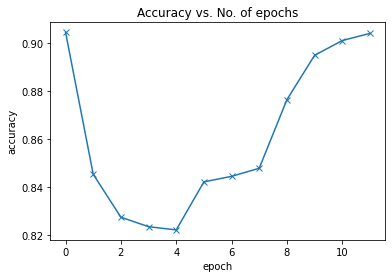

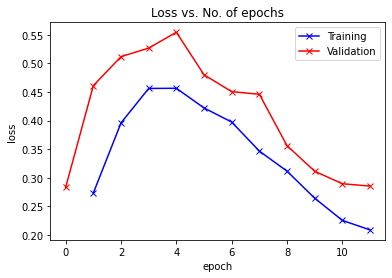

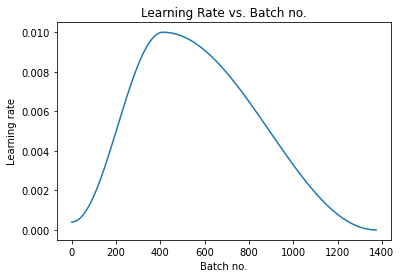

[{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}]]
Files already downloaded and verified
[{'val_loss': 2.3032028675079346, 'val_acc': 0.10519231110811234}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity92.99996447854504%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2817, val_loss: 0.4477, val_acc: 0.8479
Epoch [1], train_loss: 0.4066, val_loss: 0.5202, val_acc: 0.8244
Epoch [2], train_loss: 0.4609, val_loss: 0.6523, val_acc: 0.7878
Epoch [3], train_loss: 0.4562, val_loss: 0.6082, val_acc: 0.7990
Epoch [4], train_loss: 0.4322, val_loss: 0.6104, val_acc: 0.8096
Epoch [5], train_loss: 0.3933, val_loss

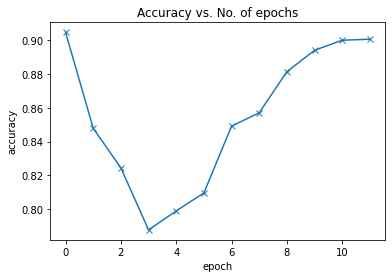

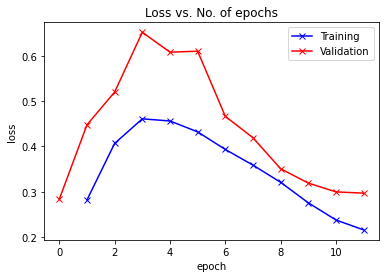

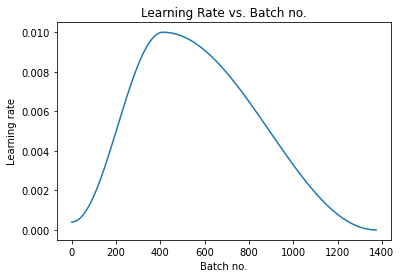

[{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}]]
Files already downloaded and verified
[{'val_loss': 2.3027751445770264, 'val_acc': 0.10067307949066162}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity93.99998223927253%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2891, val_loss: 0.4710, val_acc: 0.8410
Epoch [1], train_loss: 0.4195, val_loss: 0.5139, val_acc: 0.8284
Epoch [2], train_loss: 0.4682, val_loss: 0.5787, val_acc: 0.8067
Epoch [3], train_loss: 0.4671, val_loss: 0.5378, val_acc: 0.8262
Epoch [4], train_loss: 0.4388, val_

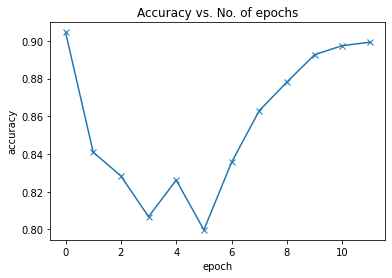

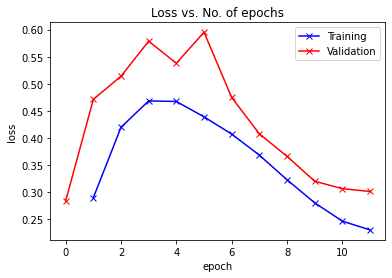

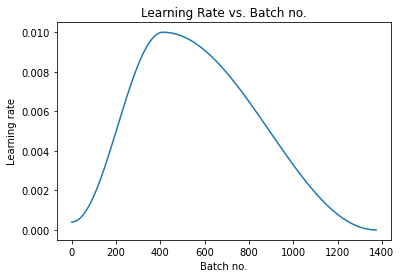

[{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}]]
Files already downloaded and verified
[{'val_loss': 2.302919864654541, 'val_acc': 0.09980770200490952}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity95.0%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.2995, val_loss: 0.5190, val_acc: 0.8239
Epoch [1], train_loss: 0.4454, val_loss: 0.4838, val_acc: 0.8416
Epoch [2], train_loss: 0.4796, val_loss: 0.5622, val_acc: 0.8158
Epoch [3], train_loss: 0.4729, val_loss: 0.5409,

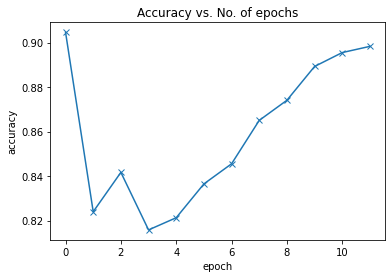

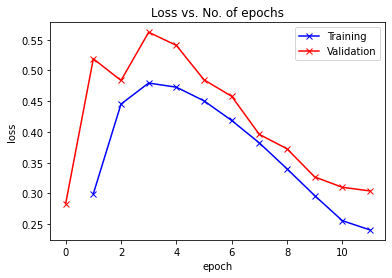

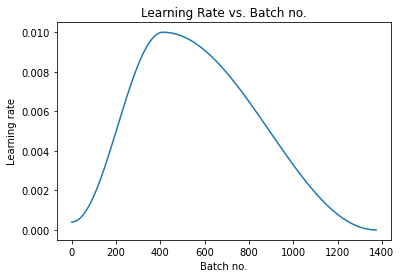

[{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}], [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}]]
Files already downloaded and verified
[{'val_loss': 2.302908182144165, 'val_acc': 0.09980770200490952}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity96.00001776072747%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.3146, val_loss: 0.6123, val_acc: 0.7915
Epoch [1], train_loss: 0.4754, val_loss: 0.5221, val_acc: 0.8225
Epoch [2], train_loss: 0.4936, 

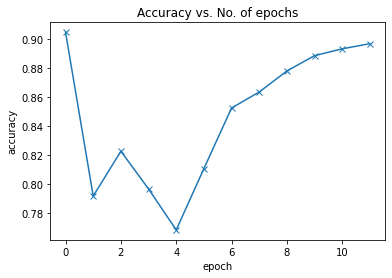

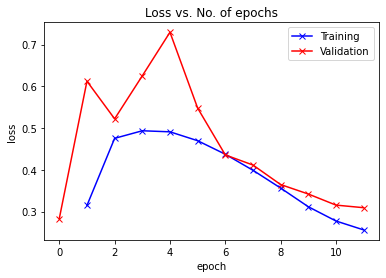

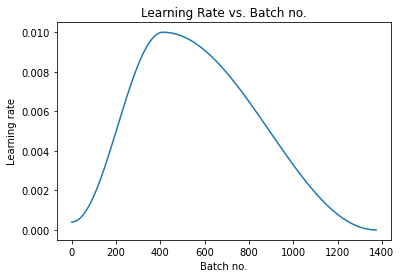

[{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}], [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}], [{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}]]
Files already downloaded and verified
[{'val_loss': 2.302783250808716, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity97.00003552145496%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0.3289, val_loss: 0.6827, val_acc: 0.7647
Epoch [1], train_loss: 0.530

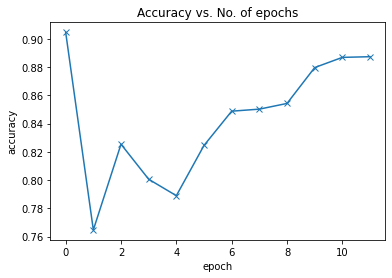

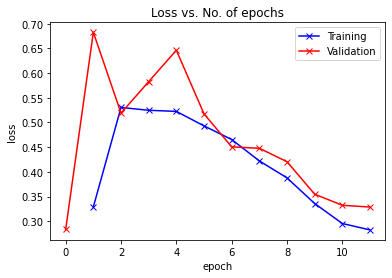

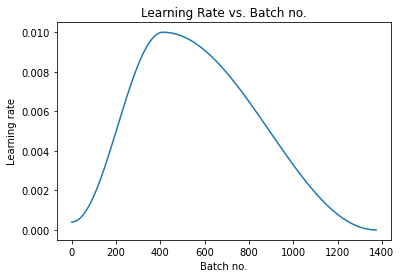

[{'val_loss': 0.32866016030311584, 'val_acc': 0.8873077034950256}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}], [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}], [{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}], [{'val_loss': 0.32866016030311584, 'val_acc': 0.8873077034950256}]]
Files already downloaded and verified
[{'val_loss': 2.3030688762664795, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity97.99996447854504%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Fine-tuning...
Epoch [0], train_loss: 0

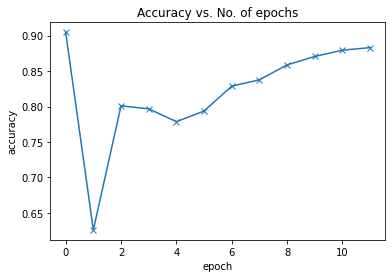

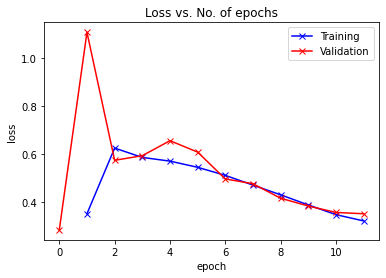

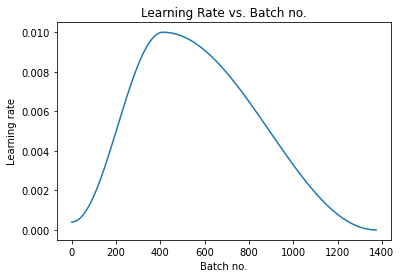

[{'val_loss': 0.35083937644958496, 'val_acc': 0.8829807639122009}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}], [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}], [{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}], [{'val_loss': 0.32866016030311584, 'val_acc': 0.8873077034950256}], [{'val_loss': 0.35083937644958496, 'val_acc': 0.8829807639122009}]]
Files already downloaded and verified
[{'val_loss': 2.3031113147735596, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity0.0%
Global Sparsity98.99998223927253%
post_pruning_history_[{'val_loss': 0.28327253460884094, 'va

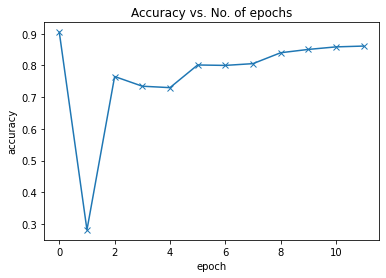

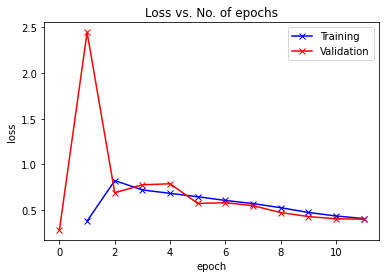

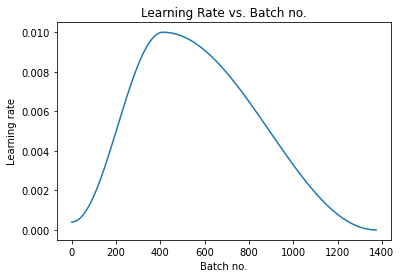

[{'val_loss': 0.40066125988960266, 'val_acc': 0.861057698726654}]
[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}], [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}], [{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}], [{'val_loss': 0.32866016030311584, 'val_acc': 0.8873077034950256}], [{'val_loss': 0.35083937644958496, 'val_acc': 0.8829807639122009}], [{'val_loss': 0.40066125988960266, 'val_acc': 0.861057698726654}]]


In [12]:
if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    percent=[]
    #iteratively pruned loaded model 
    post_finetuning_history=[]
    post_pruning_history=[]
    for i in range(10):
      stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
      train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                              tt.RandomHorizontalFlip(), 
                              # tt.RandomRotate
                              # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                              # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                              tt.ToTensor(), 
                              tt.Normalize(*stats,inplace=True)])
      valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
      # PyTorch datasets
      train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
      valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
      dataset_size = len(train_ds)
      test_dataset_size = len(valid_ds)
      # print(train_ds)
      # print(valid_ds)
      batch_size = 400

      # PyTorch data loaders
      train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
      valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
      device = get_default_device()
      # device = torch.device('cpu')
      train_dl = DeviceDataLoader(train_dl, device)
      valid_dl = DeviceDataLoader(valid_dl, device)

      model = to_device(Cifar10CnnModel(), device)
      # print(model)
      os.environ['WANDB_CONSOLE'] = 'off'
      history = [evaluate(model, valid_dl)]
      print(history)

      epochs = 11
      max_lr = 0.01
      grad_clip = 0.1
      weight_decay = 1e-4
      opt_func = torch.optim.Adam
      
      os.environ['WANDB_CONSOLE'] = 'off'
      model = to_device(Cifar10CnnModel(), device)
      percent.append((i+1)*10)
      model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt'))
      # model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt',map_location=torch.device('cpu')))
      history_final , post_pruning=iterative_pruning_finetuning(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func,input=i)
      post_finetuning_history.append(history_final)
      post_pruning_history.append(post_pruning)
      print(post_finetuning_history)
    
    

In [15]:
percent=list(range(90,100))

In [16]:

def post_finetuning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.plot(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T5/post_finetuning_accuracy.pdf',format='pdf')
    plt.show()
def post_pruning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.plot(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_pruning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T5/post_pruning_accuracy.pdf',format='pdf')
    plt.show()

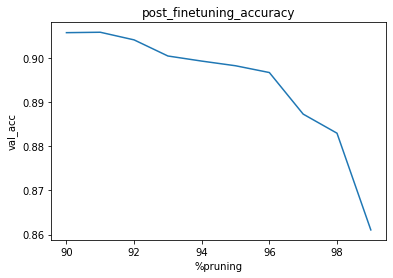

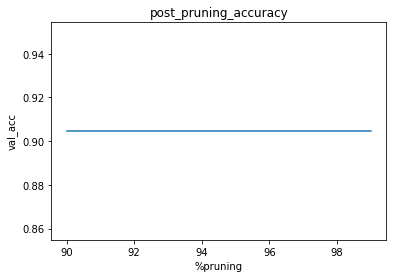

In [17]:
post_finetuning_history_plot(post_finetuning_history)
post_pruning_history_plot(post_pruning_history)